In [145]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Fairlearn - for disparity metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import false_positive_rate, true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.datasets import fetch_diabetes_hospital
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score



In [146]:
# =====================================================
# Synthetic Data Setup 
# =====================================================


data = fetch_diabetes_hospital()
X_raw = data.data   
Y = data.target     


df = X_raw.copy()
df["target"] = Y

# Downsampling
df_sampled, _ = train_test_split(
    df, 
    train_size=8000, 
    random_state=42, 
    stratify=df["race"]  # Ensuring class distribution is maintained
)
drop_candidates = ["readmitted", "readmit_binary", "target"] # Drop these columns since they are directly related to the target

# Separate features, labels, and sensitive attribute
Y_downsampled = df_sampled["target"]
A_downsampled = df_sampled["race"]          # Protected attribute
X_downsampled = df_sampled.drop(columns=drop_candidates)

# Check shapes
print("X_downsampled shape:", X_downsampled.shape)
print("Y_downsampled shape:", Y_downsampled.shape)
print("A_downsampled shape:", A_downsampled.shape)

X_downsampled shape: (8000, 22)
Y_downsampled shape: (8000,)
A_downsampled shape: (8000,)


<BarContainer object of 6 artists>

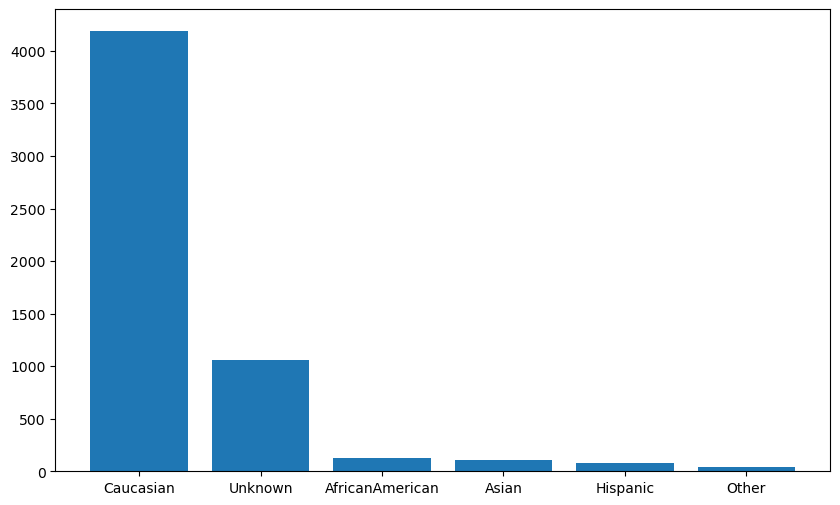

In [147]:
from matplotlib import pyplot as plt
### Distribution of sensitive attribute
plt.figure(figsize=(10, 6))
plt.bar(A_train.unique(), A_train.value_counts().values)

In [148]:
cat_cols = X_downsampled.select_dtypes(include=["object", "category"]).columns
enc = OneHotEncoder(sparse_output=False)
X_cat_array = enc.fit_transform(X_downsampled[cat_cols])
encoded_col_names = enc.get_feature_names_out(cat_cols)

In [149]:
X_cat_df = pd.DataFrame(X_cat_array, 
                        columns=encoded_col_names, 
                        index=X_downsampled.index)

# Merge one-hot encoded features with numeric columns
X_encoded = pd.concat([X_downsampled.drop(columns=cat_cols), X_cat_df], axis=1)
print(f"Shape before encoding: {X_downsampled.shape}")
print(f"Shape after encoding:  {X_encoded.shape}")

Shape before encoding: (8000, 22)
Shape after encoding:  (8000, 58)


[0]	validation_0-aucpr:0.14879
[1]	validation_0-aucpr:0.14824
[2]	validation_0-aucpr:0.14468
[3]	validation_0-aucpr:0.14365
[4]	validation_0-aucpr:0.14335
[5]	validation_0-aucpr:0.14383
[6]	validation_0-aucpr:0.14527
[7]	validation_0-aucpr:0.14529
[8]	validation_0-aucpr:0.14479
[9]	validation_0-aucpr:0.14411
[10]	validation_0-aucpr:0.14571
[11]	validation_0-aucpr:0.14478
[12]	validation_0-aucpr:0.14401
[13]	validation_0-aucpr:0.14413
[14]	validation_0-aucpr:0.14401
[15]	validation_0-aucpr:0.14440
[16]	validation_0-aucpr:0.14411
[17]	validation_0-aucpr:0.14310
[18]	validation_0-aucpr:0.14310
[19]	validation_0-aucpr:0.14399
[20]	validation_0-aucpr:0.14492
[21]	validation_0-aucpr:0.14465
[22]	validation_0-aucpr:0.14521
[23]	validation_0-aucpr:0.14492
[24]	validation_0-aucpr:0.14511
[25]	validation_0-aucpr:0.14488
[26]	validation_0-aucpr:0.14445
[27]	validation_0-aucpr:0.14462
[28]	validation_0-aucpr:0.14373
[29]	validation_0-aucpr:0.14395
[30]	validation_0-aucpr:0.14437
[31]	validation_0-

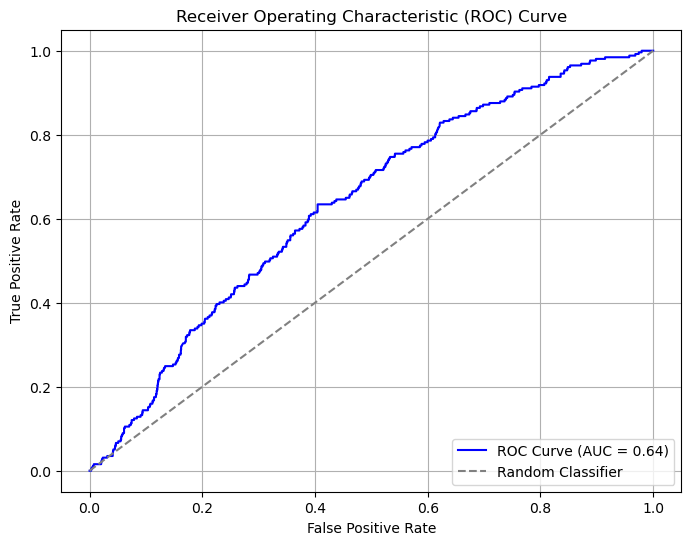

In [150]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_encoded, 
    Y_downsampled, 
    A_downsampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=A_downsampled
)

# =====================================================
# Train XGBoost Model
# =====================================================
from collections import Counter

# Calculate the scale_pos_weight
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]


model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.01,
    n_estimators=250,
    max_depth=4,          
    min_child_weight=5,   
    gamma=1,             
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
)
# model = XGBClassifier(
#     objective="binary:logistic",
#     learning_rate=0.01,
#     n_estimators=200,
#     max_depth=4,          
#     min_child_weight=3,   
#     gamma=1,             
#     eval_metric="aucpr",
#     scale_pos_weight=7.9,
# )



model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True # Set to True to see progress each round
)

### Evaluate on training data
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")
#  Evaluate on Test Data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

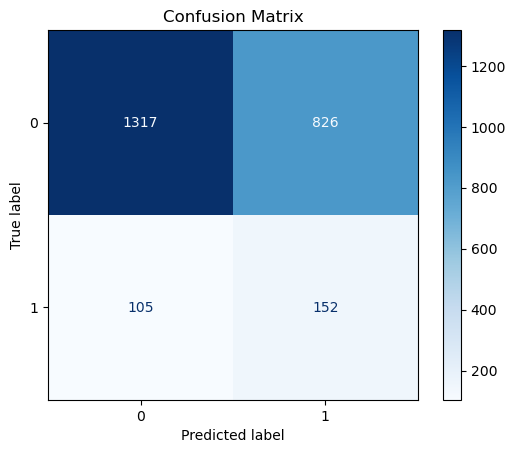

Accuracy: 0.61
Precision: 0.16
Recall: 0.59
F1 Score: 0.25


In [151]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



In [190]:
def evaluate_fairness_one_vs_rest(
    model, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    A_test: pd.Series, 
    macro: bool = False
) -> pd.DataFrame:
    """
    Evaluate fairness metrics for a binary classifier on a one-vs-rest basis for each sensitive group.
    
    For each unique group in A_test, this function computes the metrics for that group versus all other groups.
    When `macro=True`, it computes metrics for the given group and then averages the metrics of the remaining groups;
    otherwise, it uses a binary sensitive feature (group vs. rest) with fairlearn's MetricFrame.
    
    Returns:
        pd.DataFrame: A dataframe with differences in metrics (both absolute and non-absolute) and the equalized odds difference.
    """
    y_pred = model.predict(X_test)
    unique_groups = A_test.unique()
    results = []
    
    df = pd.DataFrame({
        'sensitive_feature': A_test,
        'true_label': y_test,
        'predicted_label': y_pred
    })
    
    for group_val in unique_groups:
        if macro:
            # Calculate metrics for the current group
            df_group = df[df['sensitive_feature'] == group_val]
            group_size = len(df_group)
            tpr_group = true_positive_rate(df_group['true_label'], df_group['predicted_label'])
            fpr_group = false_positive_rate(df_group['true_label'], df_group['predicted_label'])
            prec_group = precision_score(df_group['true_label'], df_group['predicted_label'])
            rec_group = recall_score(df_group['true_label'], df_group['predicted_label'])
          
            
            # Calculate metrics for the rest groups and take the average
            df_rest = df[df['sensitive_feature'] != group_val]
            rest_metrics = df_rest.groupby('sensitive_feature').apply(
                lambda x: pd.Series({
                    'TPR': true_positive_rate(x['true_label'], x['predicted_label']),
                    'FPR': false_positive_rate(x['true_label'], x['predicted_label']),
                    'Precision': (
                        precision_score(x['true_label'], x['predicted_label'])
                        if len(x['true_label'].unique()) > 1 else 0.0
                    ),
                    'Recall': (
                        recall_score(x['true_label'], x['predicted_label'])
                        if len(x['true_label'].unique()) > 1 else 0.0
                    ),
                })
            )
            tpr_rest = rest_metrics['TPR'].mean() if not rest_metrics.empty else 0.0
            fpr_rest = rest_metrics['FPR'].mean() if not rest_metrics.empty else 0.0
            prec_rest = rest_metrics['Precision'].mean() if not rest_metrics.empty else 0.0
            rec_rest = rest_metrics['Recall'].mean() if not rest_metrics.empty else 0.0
            
        else:
            # Use MetricFrame with a binary sensitive feature (group vs. rest)
            A_binary = (A_test == group_val).astype(int)
            metrics_dict = {
                "TPR": true_positive_rate,
                "FPR": false_positive_rate,
                "Precision": precision_score,
                "Recall": recall_score,
            }
            mf = MetricFrame(
                metrics=metrics_dict,
                y_true=y_test,
                y_pred=y_pred,
                sensitive_features=A_binary
            )
            by_group = mf.by_group
            # Ensure both groups (1 for current, 0 for rest) are present
            if len(by_group) < 2:
                continue
            tpr_group, tpr_rest = by_group.loc[1, "TPR"], by_group.loc[0, "TPR"]
            fpr_group, fpr_rest = by_group.loc[1, "FPR"], by_group.loc[0, "FPR"]
            prec_group, prec_rest = by_group.loc[1, "Precision"], by_group.loc[0, "Precision"]
            rec_group, rec_rest = by_group.loc[1, "Recall"], by_group.loc[0, "Recall"]
            group_size = int(A_binary.sum())
        
        # Calculate metric differences
        tpr_diff = tpr_group - tpr_rest
        fpr_diff = fpr_group - fpr_rest
        prec_diff = prec_group - prec_rest
        rec_diff = rec_group - rec_rest
        
        results.append({
            "Group": group_val,
            "group_size": group_size,
            "TPR_diff_abs": abs(tpr_diff),
            "FPR_diff_abs": abs(fpr_diff),
            "Prec_diff_abs": abs(prec_diff),
            "Recall_diff_abs": abs(rec_diff),
            "TPR_diff_nonabs": tpr_diff,
            "FPR_diff_nonabs": fpr_diff,
            "Prec_diff_nonabs": prec_diff,
            "Recall_diff_nonabs": rec_diff,
            # Equalized odds difference is typically defined as the maximum of the absolute differences of TPR and FPR.
            "equalized_odds_difference": max(abs(tpr_diff), abs(fpr_diff))
        })
    
    return pd.DataFrame(results)


In [191]:
evaluate_fairness_one_vs_rest(model, X_test, y_test, A_test,macro=True)       

/var/folders/st/ygxnyth53pb99pxw1676p2qm0000gn/T/ipykernel_77942/339034539.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_metrics = df_rest.groupby('sensitive_feature').apply(
/var/folders/st/ygxnyth53pb99pxw1676p2qm0000gn/T/ipykernel_77942/339034539.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_metrics = df_rest.groupby('sensitive_feature').apply(
/var/folders/st/ygxnyth53pb99pxw1676

,Group,group_size,TPR_diff_abs,FPR_diff_abs,Prec_diff_abs,Recall_diff_abs,TPR_diff_nonabs,FPR_diff_nonabs,Prec_diff_nonabs,Recall_diff_nonabs,equalized_odds_difference
0,Caucasian,1795,0.312222,0.152846,0.044837,0.312222,0.312222,0.152846,0.044837,0.312222,0.312222
1,AfricanAmerican,453,0.272222,0.070935,0.046156,0.272222,0.272222,0.070935,0.046156,0.272222,0.272222
2,Other,35,0.378889,0.072963,0.201061,0.378889,0.378889,0.072963,0.201061,0.378889,0.378889
3,Unknown,54,0.421111,0.176124,0.141796,0.421111,-0.421111,-0.176124,-0.141796,-0.421111,0.421111
4,Hispanic,48,0.121111,0.122648,0.008462,0.121111,-0.121111,-0.122648,-0.008462,-0.121111,0.122648
5,Asian,15,0.421111,0.002027,0.141796,0.421111,-0.421111,0.002027,-0.141796,-0.421111,0.421111


In [178]:

def compute_macro_recall(y_true, y_pred, A_test):
    
    df = pd.DataFrame({
        'race': A_test,
        'true_label': y_true,
        'predicted_label': y_pred
    })

    # Compute recall for each race
    recall_per_race = df.groupby(['race'],group_keys=False).apply(lambda x: recall_score(x['true_label'], x['predicted_label']))
    # Compute Macro Recall (Average across all races)
    macro_recall = recall_per_race.mean()

    return macro_recall

compute_macro_recall(y_test, y_pred, A_test)


    
    

/var/folders/st/ygxnyth53pb99pxw1676p2qm0000gn/T/ipykernel_77942/187762380.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recall_per_race = df.groupby(['race'],group_keys=False).apply(lambda x: recall_score(x['true_label'], x['predicted_label']))


0.3509259259259259